Extract Survival curves

In [8]:
# Use DeepSurv from the repo
import sys
sys.path.append('../deepsurv')


from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sklearn_pandas import DataFrameMapper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sklearn.model_selection import KFold

In [ ]:
#!pip install pysurvival

In [15]:
%cd /content/drive/MyDrive/Colab Notebooks/research_2021/

/content/drive/MyDrive/Colab Notebooks/research_2021


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load datasets

In [16]:
# Loading and preparing the Datasets
train_dataset_fp1 = 'New1996Chad.csv'
train_dataset_fp2 = 'New2004Chad.csv'
train_dataset_fp3 = 'New2014Chad.csv'


train_df1 = pd.read_csv(train_dataset_fp1)
train_df2 = pd.read_csv(train_dataset_fp2)
train_df3 = pd.read_csv(train_dataset_fp3)
#train_df4 = pd.read_csv(train_dataset_fp4)



Split the data into train, and test dataset


In [18]:
data_ds = train_df3.copy()
df_train = data_ds.copy()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
cols_leave = ['Data.Time', 'Data.status','Data.B4', 'Data.V025', 'Data.V149', 'Data.V190']
#cols_leave = ['Data.Time', 'Data.status','Data.b4', 'Data.v025', 'Data.v149']
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
get_target = lambda df: (df['Data.Time'].values, df['Data.status'].values)
y_train = get_target(df_train)
durations_test, events_test = get_target(df_test)


Run the deep surv model

In [19]:
## Deepsurv Input
dropout = 0.2
epochs = 1000
structure = [ {'activation': 'ReLU', 'num_units': 128}, {'activation': 'ReLU', 'num_units': 128},{'activation': 'ReLU', 'num_units': 128},{'activation': 'ReLU', 'num_units': 128}]
model_ =NonLinearCoxPHModel(structure=structure)


model_.fit(x_train, y_train[0],y_train[1], lr=1e-8,num_epochs = epochs, dropout = dropout,init_method='xav_uniform',l2_reg=1e-4, batch_normalization=True)

NonLinearCoxPHModel( Layer(1): activation = ReLU, num_units = 128 ; 
                     Layer(2): activation = ReLU, num_units = 128 ; 
                     Layer(3): activation = ReLU, num_units = 128 ; 
                     Layer(4): activation = ReLU, num_units = 128 )

Predicted survival probabilities

In [20]:

# Computing the Survival function for all times t on the test dataset
predicted = model_.predict_survival(x_test)
surv_pred= predicted.mean(axis=0)
t = model_.times
pairs = {'duration':t, '0': surv_pred}
df = pd.DataFrame.from_dict(pairs)
df.to_csv('Deep_surv_survival_Chad2014New.csv')

Plot the survival curves 


Text(0.02, 0.5, 'Survival probabilities')

<Figure size 1152x720 with 0 Axes>

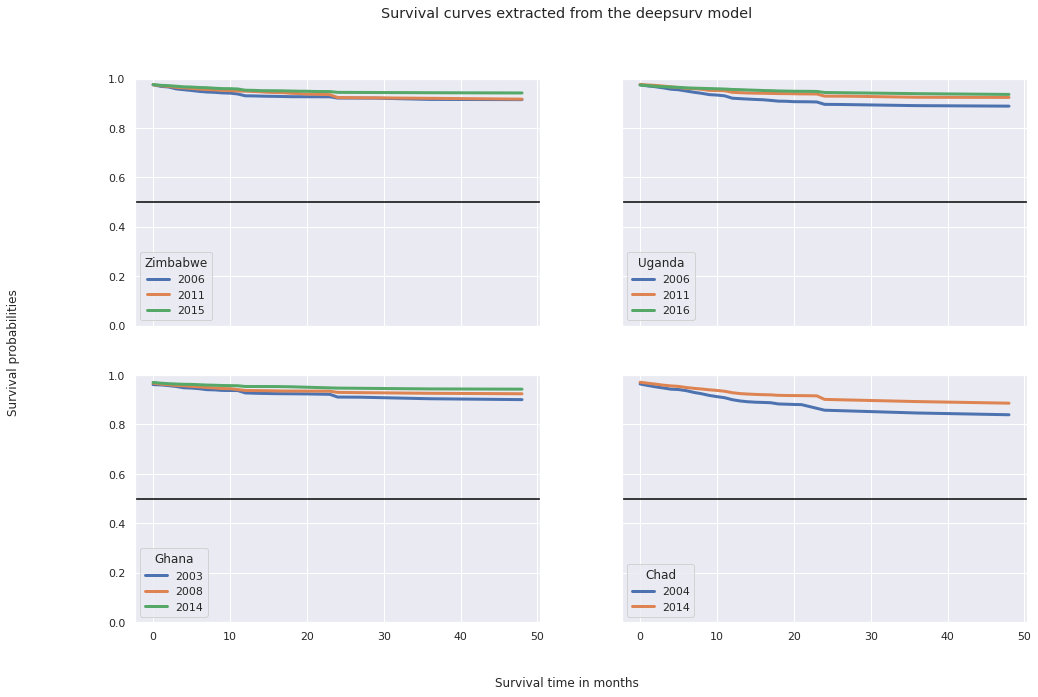

In [ ]:
# One country from each region

from numpy import *
import math
import matplotlib.pyplot as plt


# plot all the curves together

fig = plt.figure()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Survival curves extracted from the deepsurv model')
# Zimbabwe 
Zim_2006 = pd.read_csv('Deep_surv_survival_zim2006New.csv')
Zim_2011 = pd.read_csv('Deep_surv_survival_zim2011New.csv')
Zim_2015 = pd.read_csv('Deep_surv_survival_zim2015New.csv')
t1z = Zim_2006["duration"]
t2z = Zim_2011["duration"]
t3z = Zim_2015["duration"]
axs[0,0].plot(t1z, Zim_2006["0"], t2z, Zim_2011["0"], t3z,Zim_2015["0"], linewidth=3.0)
axs[0,0].legend(["2006", "2011", "2015"], title="Zimbabwe")
axs[0,0].axhline(y=0.5, color='black', linestyle='-')

# Uganda
Uganda_2006 = pd.read_csv('Deep_surv_survival_Uganda2006New.csv')
Uganda_2011 = pd.read_csv('Deep_surv_survival_Uganda2011New.csv')
Uganda_2016 = pd.read_csv('Deep_surv_survival_Uganda2016New.csv')

t1 = Uganda_2006["duration"]
t2 = Uganda_2011["duration"]
t3 = Uganda_2016["duration"]
axs[0,1].plot(t1, Uganda_2006["0"], t2, Uganda_2011["0"], t3,Uganda_2016["0"], linewidth=3.0)
axs[0,1].legend([ "2006", "2011", "2016"], title="Uganda")
axs[0,1].axhline(y=0.5, color='black', linestyle='-')

# Ghana
Ghana_2003 = pd.read_csv('Deep_surv_survival_Ghana2003New.csv')
Ghana_2008 = pd.read_csv('Deep_surv_survival_Ghana2008New.csv')
Ghana_2014 = pd.read_csv('Deep_surv_survival_Ghana2014New.csv')
t1G = Ghana_2003["duration"]
t2G = Ghana_2008["duration"]
t3G = Ghana_2014["duration"]
axs[1,0].plot( t1G, Ghana_2003["0"],t2G, Ghana_2008["0"], t3G,Ghana_2014["0"], linewidth=3.0)
axs[1,0].legend(["2003", "2008", "2014"], title="Ghana")
axs[1,0].axhline(y=0.5, color='black', linestyle='-')

# Chad
Chad_2004 = pd.read_csv('Deep_surv_survival_Chad2004New.csv')
Chad_2014 = pd.read_csv('Deep_surv_survival_Chad2014New.csv')
t1C = Chad_2004["duration"]
t2C = Chad_2014["duration"]
axs[1,1].plot( t1C, Chad_2004["0"], t2C, Chad_2014["0"], linewidth=3.0)
axs[1,1].legend(["2004", "2014"], title="Chad")
axs[1,1].set_ylim(ymin=0)
axs[1,1].axhline(y=0.5, color='black', linestyle='-')

fig.text(0.5, 0.04, 'Survival time in months', ha='center', va='center')
fig.text(0.02, 0.5, 'Survival probabilities', ha='center', va='center', rotation='vertical')


10-fold cross validation

Load datasets


In [ ]:
train_dataset_fp1 = 'New1996Chad.csv'
train_dataset_fp2 = 'New2004Chad.csv'
train_dataset_fp3 = 'New2014Chad.csv'
#train_dataset_fp4 = 'New2014Ghana.csv'
train_df1 = pd.read_csv(train_dataset_fp1)
train_df2 = pd.read_csv(train_dataset_fp2)
train_df3 = pd.read_csv(train_dataset_fp3)
#train_df4 = pd.read_csv(train_dataset_fp4)

Data splitting

In [ ]:

cv =KFold(n_splits=10,random_state=42, shuffle=False)
train_index1= list()
train_index2= list()
train_index3= list()
train_index4= list()
test_index1= list()
test_index2= list()
test_index3= list()
test_index4= list()
for i in cv.split(train_df1):
    train_index1.append(i[0])
    test_index1.append(i[1])
for j in cv.split(train_df2):
    train_index2.append(j[0])
    test_index2.append(j[1])
for k in cv.split(train_df3):
    train_index3.append(k[0])
    test_index3.append(k[1])
#for b in cv.split(train_df4):
 #   train_index4.append(b[0])
 #   test_index4.append(b[1])
    

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



Run the model

In [ ]:
scores1 = []
scores2 = []
scores3 = []
scores4 = []
l=0
while  l<10:
    #1999
    df1 = train_df1.iloc[test_index1[l],:]
    dft1=train_df1.iloc[test_index1[l],:]
    df_train1 = df1
    df_test1 = dft1
    #cols_leave = ['Data.Time', 'Data.status','Data.B4', 'Data.V025', 'Data.V149', 'Data.V190']
    cols_leave = ['Data.Time', 'Data.status','Data.b4', 'Data.v025', 'Data.v149']
    leave = [(col, None) for col in cols_leave]
    x_mapper = DataFrameMapper(leave)
    x_train1 = x_mapper.fit_transform(df_train1).astype('float32')
    x_test1 = x_mapper.transform(df_test1).astype('float32')
    get_target = lambda df: (df['Data.Time'].values, df['Data.status'].values)
    y_train1 = get_target(df_train1)
    durations_test1, events_test1 = get_target(df_test1)
    ##2006
    df2 = train_df2.iloc[test_index2[l],:]
    dft2=train_df2.iloc[test_index2[l],:]

    df_train2 = df2
    df_test2 = dft2
    cols_leave = ['Data.Time', 'Data.status','Data.B4', 'Data.V025', 'Data.V149', 'Data.V190']
    leave = [(col, None) for col in cols_leave]
    x_mapper = DataFrameMapper(leave)
    x_train2 = x_mapper.fit_transform(df_train2).astype('float32')
    x_test2 = x_mapper.transform(df_test2).astype('float32')
    get_target = lambda df: (df['Data.Time'].values, df['Data.status'].values)
    y_train2 = get_target(df_train2)
    durations_test2, events_test2 = get_target(df_test2)
    ##2011
    df3 = train_df3.iloc[test_index3[l],:]
    dft3=train_df3.iloc[test_index3[l],:]
    df_train3 = df3
    df_test3 = dft3
    cols_leave = ['Data.Time', 'Data.status','Data.B4', 'Data.V025', 'Data.V149', 'Data.V190']
    leave = [(col, None) for col in cols_leave]
    x_mapper = DataFrameMapper(leave)
    x_train3 = x_mapper.fit_transform(df_train3).astype('float32')
    x_test3 = x_mapper.transform(df_test3).astype('float32')
    get_target = lambda df: (df['Data.Time'].values, df['Data.status'].values)
    y_train3 = get_target(df_train3)
    durations_test3, events_test3 = get_target(df_test3)
    ##2015
    #df4 = train_df4.iloc[test_index4[l],:]
    #dft4=train_df4.iloc[test_index4[l],:]
    #df_train4 = df4
    #df_test4 = dft4
    #cols_leave = ['Data.Time', 'Data.status','Data.B4', 'Data.V025', 'Data.V149', 'Data.V190']
    #leave = [(col, None) for col in cols_leave]
    #x_mapper = DataFrameMapper(leave)
    #x_train4 = x_mapper.fit_transform(df_train4).astype('float32')
    #x_test4 = x_mapper.transform(df_test4).astype('float32')
    #get_target = lambda df: (df['Data.Time'].values, df['Data.status'].values)
    #y_train4 = get_target(df_train4)
    #durations_test4, events_test4 = get_target(df_test4)
# model parameters
    dropout = 0.2
    epochs = 1000
    structure = [ {'activation': 'ReLU', 'num_units': 128}, {'activation': 'ReLU', 'num_units': 128},{'activation': 'ReLU', 'num_units': 128},{'activation': 'ReLU', 'num_units': 128}]
    # model 1
    model1 =NonLinearCoxPHModel(structure=structure)
    model1.fit(x_train1, y_train1[0],y_train1[1], lr=1e-8,num_epochs = epochs, dropout = dropout,init_method='xav_uniform',l2_reg=1e-4, batch_normalization=True)
# model 2    
    model2 =NonLinearCoxPHModel(structure=structure)
    model2.fit(x_train2, y_train2[0],y_train2[1], lr=1e-8,num_epochs = epochs, dropout = dropout,init_method='xav_uniform',l2_reg=1e-4,batch_normalization=True)
# model 3
    model3 =NonLinearCoxPHModel(structure=structure)
    model3.fit(x_train3, y_train3[0],y_train3[1], lr=1e-8,num_epochs = epochs, dropout = dropout,init_method='xav_uniform',l2_reg=1e-4,batch_normalization=True)
# model 4
    #model4 =NonLinearCoxPHModel(structure=structure)
    #model4.fit(x_train4, y_train4[0],y_train4[1], lr=1e-8,num_epochs = epochs, dropout = dropout,init_method='xav_uniform',l2_reg=1e-4, batch_normalization=True)
# C-index 
#1999
    scores1.append(concordance_index(model1,x_test1,durations_test1,events_test1))
#2006
    scores2.append(concordance_index(model2,x_test2,durations_test2,events_test2))
#2011
    scores3.append(concordance_index(model3,x_test3,durations_test3,events_test3))
#2015
    #scores4.append(concordance_index(model4,x_test4,durations_test4,events_test4))
    l+=1
#plt.boxplot(scores)
#deepsurv.plot_log(metrics)

Store results

In [ ]:
ChadResultsNew = pd.DataFrame()
ChadResultsNew['1996']  = scores1
ChadResultsNew['2004']  = scores2
ChadResultsNew['2014']  = scores3
#GhanaResultsNew['2014']  = scores4
ChadResultsNew
ChadResultsNew.to_csv('ChadResultsNew.csv')

Plot results 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
from pylab import *

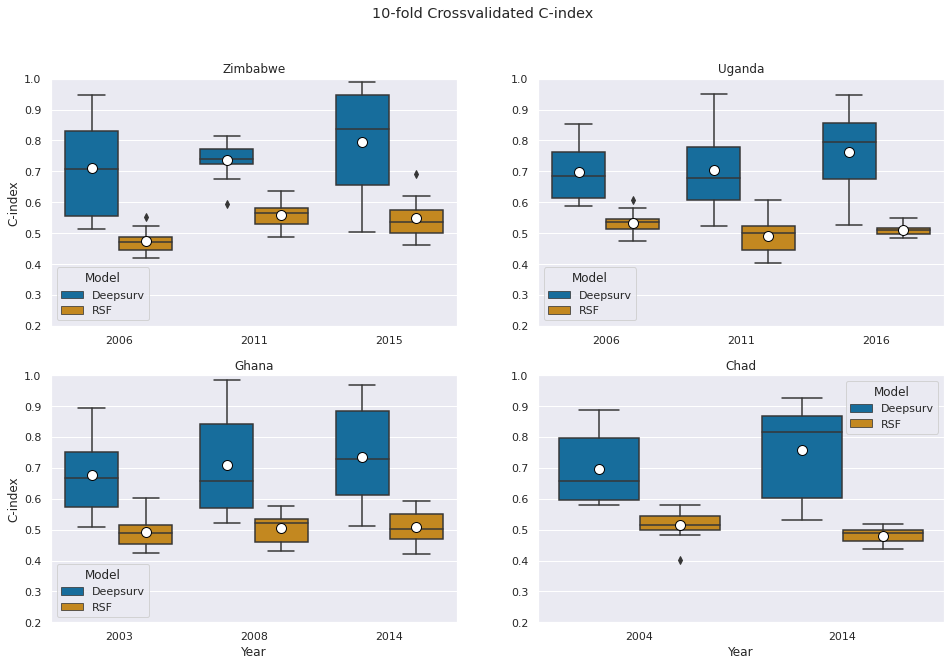

In [ ]:
# One country from each region

sns.set(rc={"figure.figsize": (16, 10)})
plt.suptitle("10-fold Crossvalidated C-index") 

subplot(2,2,1)
# Zimbabwe
RSF_zim = 'Zim_RSF.csv'
RSF_zim = pd.read_csv(RSF_zim)
New = pd.DataFrame(RSF_zim)
ZimbabweResults =  'ZimbabweResultsNew.csv'
ZimbabweResults = pd.read_csv(ZimbabweResults)
ZimbabweResults= ZimbabweResults.drop(['1999'], axis=1)
df = pd.concat([ZimbabweResults, New])
g = ['Deepsurv','RSF']
K =10
model = list(itertools.chain.from_iterable(itertools.repeat(i, K) for i in g)) 
df["model"] = model
df = pd.melt(df, id_vars=['model'], value_vars=[ '2006','2011','2015'])
df.columns = ['Model', 'Year', 'C-index']
ax= sns.boxplot(y='C-index', x='Year', 
                 data=df, 
                 palette="colorblind",
                 hue='Model',showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
ax.set(xlabel=None)
ax.set(title='Zimbabwe')
ax.set_ylim([0.2,1])
subplot(2,2,2)
# Uganda
RSF_Uganda = 'Uganda_RSF.csv'
RSF_Uganda = pd.read_csv(RSF_Uganda)
New = pd.DataFrame(RSF_Uganda)
UgandaResults =  'UgandaResultsNew.csv'
UgandaResults = pd.read_csv(UgandaResults)
UgandaResults = UgandaResults.drop(['2001'], axis=1)
df = pd.concat([UgandaResults, New])
g = ['Deepsurv','RSF']
K =10
model = list(itertools.chain.from_iterable(itertools.repeat(i, K) for i in g)) 
df["model"] = model
df = pd.melt(df, id_vars=['model'], value_vars=['2006','2011','2016'])
df.columns = ['Model', 'Year', 'C-index']
ax= sns.boxplot(y='C-index', x='Year', 
                 data=df, 
                 palette="colorblind",
                 hue='Model',showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
ax.set(ylabel=None)
ax.set(xlabel=None)
ax.set(title='Uganda')
ax.set_ylim([0.2,1])

subplot(2,2,3)

# Ghana
RSF_Ghana = 'Ghana_RSF.csv'
RSF_Ghana = pd.read_csv(RSF_Ghana)
New = pd.DataFrame(RSF_Ghana)
GhanaResults =  'GhanaResultsNew.csv'
GhanaResults = pd.read_csv(GhanaResults)
GhanaResults = GhanaResults.drop(['1998'], axis=1)
df = pd.concat([GhanaResults, New])
g = ['Deepsurv','RSF']
K =10
model = list(itertools.chain.from_iterable(itertools.repeat(i, K) for i in g)) 
df["model"] = model
df = pd.melt(df, id_vars=['model'], value_vars=['2003','2008','2014'])
df.columns = ['Model', 'Year', 'C-index']
ax = sns.boxplot(y='C-index', x='Year', 
                 data=df, 
                 palette="colorblind",
                 hue='Model',showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
ax.set(title='Ghana')
ax.set_ylim([0.2,1])
subplot(2,2,4)
# Chad
RSF_Chad = 'Chad_RSF.csv'
RSF_Chad = pd.read_csv(RSF_Chad)
New = pd.DataFrame(RSF_Chad)
ChadResults =  'ChadResultsNew.csv'
ChadResults = pd.read_csv(ChadResults)
ChadResults = ChadResults.drop(['1996'], axis=1)
df = pd.concat([ChadResults, New])
g = ['Deepsurv','RSF']
K =10
model = list(itertools.chain.from_iterable(itertools.repeat(i, K) for i in g)) 
df["model"] = model
df = pd.melt(df, id_vars=['model'], value_vars=['2004','2014'])
df.columns = ['Model', 'Year', 'C-index']
ax = sns.boxplot(y='C-index', x='Year', 
                 data=df, 
                 palette="colorblind",
                 hue='Model',showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
ax.set(ylabel=None)
ax.set(title='Chad')
ax.set_ylim([0.2,1])
#plt.show()

# save the plot as a file
plt.savefig('CVCINDEX.tif', transparent=True, dpi=350, bbox_inches="tight", pad_inches=0.0)



In [ ]:
train_dataset_fp1 = 'New2001Uganda.csv'
train_dataset_fp2 = 'New2006Uganda.csv'
train_dataset_fp3 = 'New2011Uganda.csv'
train_dataset_fp4 = 'New2016Uganda.csv'


train_dataset_fp1 = 'New1999Zim.csv'
train_dataset_fp2 = 'New2006Zim.csv'
train_dataset_fp3 = 'New2011Zim.csv'
train_dataset_fp4 = 'New2015Zim.csv'


train_dataset_fp1 = 'New1998Ghana.csv'
train_dataset_fp2 = 'New2003Ghana.csv'
train_dataset_fp3 = 'New2008Ghana.csv'
train_dataset_fp4 = 'New2014Ghana.csv'

train_dataset_fp1 = 'New1996Chad.csv'
train_dataset_fp2 = 'New2004Chad.csv'
train_dataset_fp3 = 'New2014Chad.csv'

Results 

ZimbabweResultsNew = pd.DataFrame()
ZimbabweResultsNew['1999']  = scores1
ZimbabweResultsNew['2006']  = scores2
ZimbabweResultsNew['2011']  = scores3
ZimbabweResultsNew['2015']  = scores4
ZimbabweResultsNew
#ZimbabweResultsNew.to_csv('ZimbabweResultsNew.csv')

UgandaResultsNew = pd.DataFrame()
UgandaResultsNew['2001']  = scores1
UgandaResultsNew['2006']  = scores2
UgandaResultsNew['2011']  = scores3
UgandaResultsNew['2016']  = scores4
UgandaResultsNew
#UgandaResultsNew.to_csv('UgandaResultsNew.csv')

GhanaResultsNew = pd.DataFrame()
GhanaResultsNew['1998']  = scores1
GhanaResultsNew['2003']  = scores2
GhanaResultsNew['2008']  = scores3
GhanaResultsNew['2014']  = scores4
GhanaResultsNew
#GhanaResultsNew.to_csv('GhanaResultsNew.csv')

ChadResultsNew = pd.DataFrame()
ChadResultsNew['1996']  = scores1
ChadResultsNew['2004']  = scores2
ChadResultsNew['2014']  = scores3
#GhanaResultsNew['2014']  = scores4
ChadResultsNew
#ChadResultsNew.to_csv('ChadResultsNew.csv')

In [ ]:
train_df2

,Unnamed: 0,Data.Time,Data.status,Data.B4,Data.V025,Data.V149,Data.V190
0,1,28,0,2,2,3,5
1,2,55,0,2,2,3,5
2,3,35,0,2,2,4,5
3,4,6,0,1,2,5,5
4,5,49,0,1,2,5,5
...,...,...,...,...,...,...,...
3839,3840,20,0,1,2,3,2
3840,3841,41,0,1,2,3,2
3841,3842,32,0,2,2,3,5
3842,3843,41,0,1,2,1,2
